 #                                     Strarcraft 2 prediction Player

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from pandas.plotting import parallel_coordinates,scatter_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt

## Important Variables

In [3]:
#To be sure that we get all the right keys
CSV_KEYS = ['id', 'class', 's', 'sBase', 'sMineral', 'order']
for i in range(10):
    CSV_KEYS.append('hotkey' + str(i))

#Define map class->value
CLASSES = {}

#Zerg -> 0
#Protoss -> 1
#Terran -> 2
CLASSES['Zerg'] = 0
CLASSES['Protoss'] = 1
CLASSES['Terran'] = 2

#Define Directories
OUTPUT = '../data/output'
OUTPUT_SUB = OUTPUT
OUTPUT_CHARTS = OUTPUT + '/charts/'
INPUT = '../data/input'
INPUT_TRAIN = INPUT + '/TRAIN.CSV'
INPUT_TEST = INPUT + '/TEST.CSV'

## Reading Data

In [4]:
import csv
from collections import defaultdict
csv_file = '../data/input/TRAIN.CSV'

def get_train_data_old():    
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []
        ids = []

        for row in cvs_reader:

            ids.append(row[0])
            train_dict = defaultdict(int)
            train_dict['id'] = row[0]
            train_dict['class'] = row[1]

            t = 0
            for i in range(1, len(row)-2):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    train_dict[row[len(row)-i][:-1]] += 1/t
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            data.append(train_dict)
        
def get_train_data(csv_file=INPUT_TRAIN):
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []
        ids = []
        #Representation des actions faites dans l'ordre
        ord_representation = ''
        
        for row in cvs_reader:

            #Initialize to zero
            csv_dict = zero_dict()
            ord_representation = ''
                
            csv_dict['id'] = row[0]
            ids.append(row[0])
            csv_dict['class'] = CLASSES[row[1]]
            t = 0
            for i in range(1, len(row)-2):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    csv_dict[row[len(row)-i][:-1]] += 1/t
                    ord_representation += row[len(row)-i][-2:-1]
                    
                if 'Base' in row[len(row)-i] and t != 0:
                    csv_dict['sBase'] += 1/t
                    
                if 'Mineral' in row[len(row)-i] and t != 0:
                    csv_dict['sMineral'] += 1/t
                    
                if 's' == row[len(row)-i] and t != 0:
                    csv_dict['s'] += 1/t
                    
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            csv_dict['order'] = ord_representation#hash(ord_representation) #Faire integer
            data.append(csv_dict)
        return (data, ids)
    
def zero_dict():
    new_dict = {}
    #Initialize to zero
    for i in CSV_KEYS:
        new_dict[i] = 0
    return new_dict

In [5]:
data, ids= get_train_data()
df = pd.DataFrame(data, columns=data[0].keys()) 
print('Shape of the dataset: ' + str(df.shape))
df.sample(n=5).fillna(0)

Shape of the dataset: (3052, 16)


,id,class,s,sBase,sMineral,order,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9
1941,http://us.battle.net/sc2/en/profile/4417787/1/...,0,0.821918,0.038356,0.001370,1414141414141414141114141414141410141181411141...,0.084932,0.461644,0.108219,0.123288,0.536986,0.068493,0.013699,0.016438,0.017808,0.000000
271,http://eu.battle.net/sc2/en/profile/377576/1/L...,1,0.625217,0.024348,0.002609,2224422222222222222442612244222222224422222222...,0.000000,0.471304,0.666957,0.411304,0.140870,0.309565,0.058261,0.030435,0.000000,0.000000
2176,http://us.battle.net/sc2/en/profile/4174681/1/...,1,0.342400,0.012800,0.000000,2112111121121212121111212113153214212112142111...,0.001600,0.361600,0.051200,0.449600,0.348800,0.088000,0.001600,0.001600,0.001600,0.001600
2250,http://kr.battle.net/sc2/en/profile/2343531/1/...,2,0.525234,0.000000,0.001869,1114711654143111111114776465465465465465456546...,0.000935,0.180374,0.221495,0.121495,0.237383,0.114953,0.104673,0.055140,0.002804,0.009346
2527,http://kr.battle.net/sc2/en/profile/2343240/1/...,1,0.717241,0.136207,0.000000,6861616161616161818181262626216216262143143114...,0.001724,0.468966,0.296552,0.641379,0.384483,0.170690,0.079310,0.000000,0.020690,0.003448


In [65]:
print(data[561])

{'id': 'http://us.battle.net/sc2/en/profile/2735594/1/coLqxc/', 'class': 2, 's': 0.2, 'sBase': 0, 'sMineral': 0.1, 'order': '1', 'hotkey0': 0, 'hotkey1': 0.1, 'hotkey2': 0, 'hotkey3': 0, 'hotkey4': 0, 'hotkey5': 0, 'hotkey6': 0, 'hotkey7': 0, 'hotkey8': 0, 'hotkey9': 0}


# EDA ( Exploratory Data Analysis) 

## Nombre de parties par joueur

In [7]:
df.groupby('id').id.count().reset_index(name='count').sort_values('count',ascending=False)

,id,count
131,http://kr.battle.net/sc2/en/profile/2348639/1/...,58
86,http://kr.battle.net/sc2/en/profile/2342419/1/...,51
73,http://kr.battle.net/sc2/en/profile/2341467/1/...,50
49,http://eu.battle.net/sc2/en/profile/3973341/1/...,44
66,http://kr.battle.net/sc2/en/profile/2332264/1/...,42
...,...,...
139,http://us.battle.net/sc2/en/profile/2192180/1/...,4
36,http://eu.battle.net/sc2/en/profile/3434150/1/...,4
84,http://kr.battle.net/sc2/en/profile/2342299/1/...,4
172,http://us.battle.net/sc2/en/profile/4580957/1/...,4


Mauvaise répartion des parties pour chaque joueur. Certains ont joués que 4 parties alors que d'autres 50. Comment résoudre cela ? ==> SMOTE ? ADASYN ? permet de over-sampling !!!

In [8]:
df.groupby('id').id.count().reset_index(name='count').sort_values('count',ascending=False).describe()


,count
count,200.00000
mean,15.26000
std,10.41464
min,4.00000
25%,7.00000
50%,12.00000
75%,20.00000
max,58.00000


## Nombre de joueur

In [9]:

nb_joueur = list(dict.fromkeys(ids))
print(len(nb_joueur))

200


In [10]:
nb_joueur = list(dict.fromkeys(ids))
print(nb_joueur)

['http://eu.battle.net/sc2/en/profile/4234852/1/First/', 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/', 'http://eu.battle.net/sc2/en/profile/3401218/1/Welmu/', 'http://eu.battle.net/sc2/en/profile/2896854/1/MÇ‚ForGG/', 'http://eu.battle.net/sc2/en/profile/3538115/1/Golden/', 'http://eu.battle.net/sc2/en/profile/250458/1/VortiX/', 'http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/', 'http://eu.battle.net/sc2/en/profile/2452136/1/MinChul/', 'http://eu.battle.net/sc2/en/profile/2222468/1/dTefel/', 'http://eu.battle.net/sc2/en/profile/4341883/1/Patience/', 'http://eu.battle.net/sc2/en/profile/950504/1/Grubby/', 'http://eu.battle.net/sc2/en/profile/2898004/1/MMA/', 'http://eu.battle.net/sc2/en/profile/251061/1/LiveZerg/', 'http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/', 'http://eu.battle.net/sc2/en/profile/326029/1/LiquidTLO/', 'http://eu.battle.net/sc2/en/profile/1058669/1/Happy/', 'http://eu.battle.net/sc2/en/profile/1139573/1/BabyKnight/', 'http://eu.battle.net/

## Repartition des races

On essaye de comprendre l'influence de la race sur le joueur : il y a t-il des joueurs qui change de champion ?

Protoss    1210
Zerg       1061
Terran      781
Name: class, dtype: int64


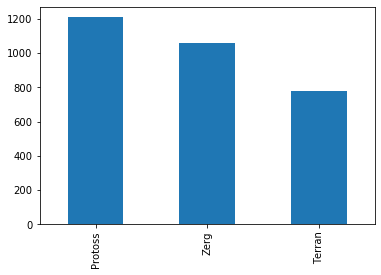

In [11]:
races = df['class'].value_counts()
print(races)
races.plot.bar()

In [37]:
df.groupby(['class','id'])['id'].count()

class  id                                                         
0      http://eu.battle.net/sc2/en/profile/1173786/1/VPbenQsLivko/    12
       http://eu.battle.net/sc2/en/profile/2048063/1/AcerBly/         13
       http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/        12
       http://eu.battle.net/sc2/en/profile/2115876/1/FireCake/        16
       http://eu.battle.net/sc2/en/profile/219517/1/TargA/             7
                                                                      ..
2      http://xx.battle.net/sc2/en/profile/405/1/MMA/                  4
       http://xx.battle.net/sc2/en/profile/406/1/INnoVation/           4
       http://xx.battle.net/sc2/en/profile/408/1/Polt/                 6
       http://xx.battle.net/sc2/en/profile/410/1/STBomber/            15
       http://xx.battle.net/sc2/en/profile/413/1/Maru/                15
Name: id, Length: 200, dtype: int64

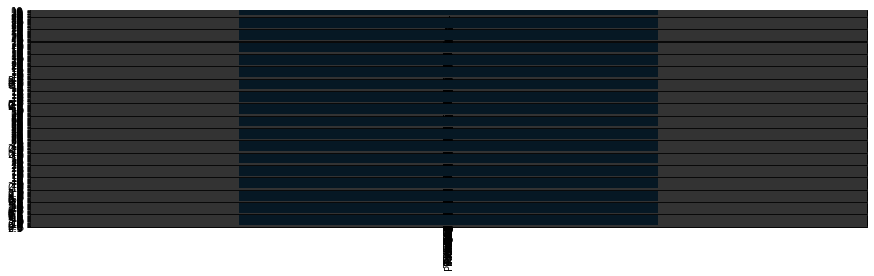

In [13]:


f,ax=plt.subplots(200,1,figsize=(15,4))
dfi = df.set_index("id")


for i in range (0,200) :
    races_joueur = dfi.loc[nb_joueur[i]]['class'].value_counts()
    races_joueur.plot.bar(ax=ax[i])
    
    
plt.show()  

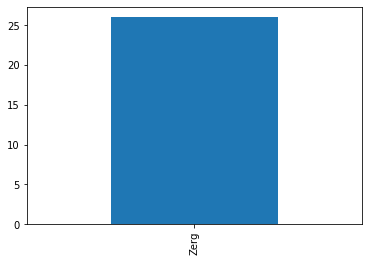

In [14]:
races_joueur = dfi.loc[ids[100]]['class'].value_counts()
races_joueur.plot.bar()

### Remarque : Chaque joueur ne joue qu'un seul type de personnage ( ligne droite pas de déviation). Donc cette feature est très importante pour nous. !!!!!

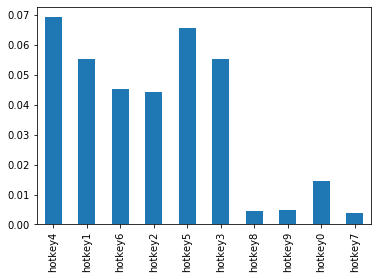

In [15]:
df.var().plot.bar()

on pourrait supprimer les hotckey 8,9 , 0 ,7 car ils sont très peu fréquents ( biais pour la classification)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F4B7B3D48>,
      dtype=object)

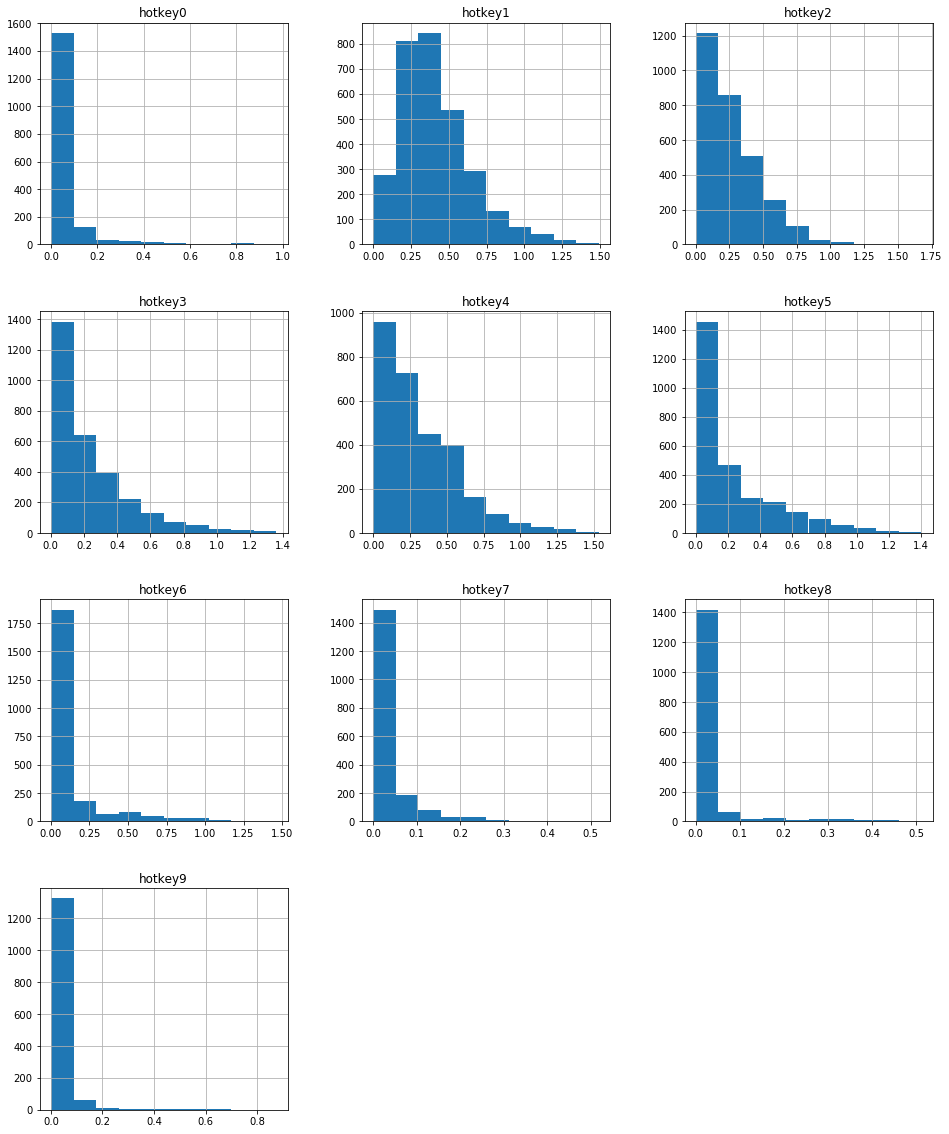

In [16]:
df.hist(figsize = (16,20), stacked= False)

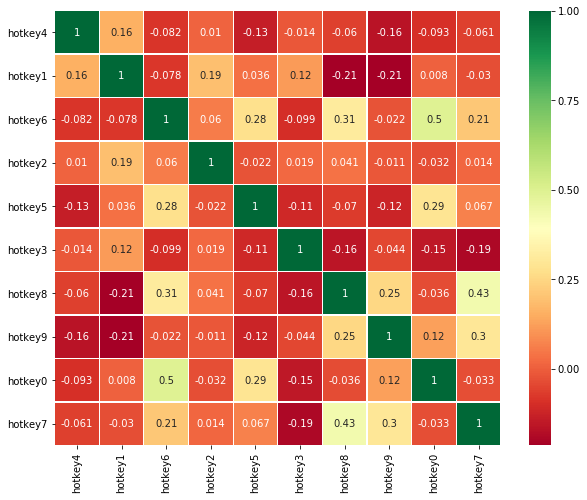

In [17]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Les corrélations ne sont pas suffisante pour pouvoir appliquer une supprésion de features. les features sont tous bien corrolé . Voir avec race ??

## Ordre des touches appuyée

Il se pourrait que les touches (au moins les prémières) appuyé soit caractéristiques pour chaque jouer

In [8]:
temp_table = {'range': [], 'nmLines': []}

In [19]:
idxInit = 0
idxEnd = 3

In [20]:
df_temp = df.copy(deep=True)
for i, value in enumerate(df_temp['order']):
    df_temp.loc[i, ('orderPart')] = '{:<20}'.format(value)[idxInit:idxEnd]

temp_table['range'].append(str(idxInit) + ':' + str(idxEnd))
temp_table['nmLines'].append(
    len(df_temp.groupby(['id', 'orderPart'])['orderPart'].count()))
df_temp.groupby(['id', 'orderPart'])['orderPart'].count()

id                                                     orderPart
http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/  111          2
                                                       112          1
                                                       121          3
                                                       122          5
                                                       124          1
                                                                   ..
http://xx.battle.net/sc2/en/profile/415/1/EGJD/        441          1
                                                       444          1
                                                       455          1
                                                       465          1
                                                       515          1
Name: orderPart, Length: 1927, dtype: int64

J'ai testé avec les index, et le nombre des résultats (lignes) est: 

In [144]:
print('Range\tnmLines')
temp_table
for i, val in enumerate(temp_table['range']):
    print('{}\t{}'.format(val, temp_table['nmLines'][i]))

Range	nmLines
0:5	2417
5:10	2444
0:10	2806
0:1	777
0:2	1480
1:2	809
2:3	792
2:4	1512
3:4	813


Les index qui ont donnés le moindre de ligne sont: [0:1](777), [2:3](792), [1:2](809)
Donc s'il y a une différence, elle doit se trouver dans la/les prémière/s touche/s appuyé/es

In [21]:
#Obtenir les sequences plus frequentes de chaque jouer
df_max_seq = df_temp.groupby(['id', 'orderPart']).orderPart.count().reset_index(name='count').sort_values('count', ascending=False).drop_duplicates(subset='id', keep='first')
df_max_seq

,id,orderPart,count
1186,http://kr.battle.net/sc2/en/profile/2344031/1/...,444,18
563,http://eu.battle.net/sc2/en/profile/788178/1/N...,111,16
105,http://eu.battle.net/sc2/en/profile/2222468/1/...,111,15
1330,http://kr.battle.net/sc2/en/profile/2344987/1/...,141,13
319,http://eu.battle.net/sc2/en/profile/326029/1/L...,666,11
...,...,...,...
844,http://kr.battle.net/sc2/en/profile/2342294/1/...,532,1
1074,http://kr.battle.net/sc2/en/profile/2343531/1/...,676,1
1003,http://kr.battle.net/sc2/en/profile/2343183/1/...,999,1
542,http://eu.battle.net/sc2/en/profile/4860568/1/...,112,1


Voyons l'unicité de chaque séquence

In [56]:
df_repeted_seq = df_max_seq.drop_duplicates(subset='orderPart', keep='first')
df_repeted_seq

,id,orderPart,count
1186,http://kr.battle.net/sc2/en/profile/2344031/1/...,444,18
563,http://eu.battle.net/sc2/en/profile/788178/1/N...,111,16
1330,http://kr.battle.net/sc2/en/profile/2344987/1/...,141,13
319,http://eu.battle.net/sc2/en/profile/326029/1/L...,666,11
1043,http://kr.battle.net/sc2/en/profile/2343479/1/...,515,11
...,...,...,...
926,http://kr.battle.net/sc2/en/profile/2342766/1/...,512,1
844,http://kr.battle.net/sc2/en/profile/2342294/1/...,532,1
1074,http://kr.battle.net/sc2/en/profile/2343531/1/...,676,1
1003,http://kr.battle.net/sc2/en/profile/2343183/1/...,999,1


Puisqu'il y a seulement 68 sequences uniques pour 200 jouers, on ne peut pas dire si ces données seront ou pas utiles! :(